In [5]:
# !pip install openai weave

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
PROJECT="weave-intro-notebook"

#### Track your custom functions

In [6]:
from openai import OpenAI
import weave
weave.init(PROJECT) # Auto tracing of all calls to OpenAI

Logged in as Weights & Biases user: paul-mriganka.
View Weave data at https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/weave


### Tracing

In [7]:
client = OpenAI()
response = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {
             "role": "system",
            "content": "You are a grammar checker, correct the following user input.",
        },
        {
            "role": "user", "content": "That was so easy, it was a piece of pie!"
        }
    ],
    temperature = 0,
)
generation = response.choices[0].message.content
print(generation)

🍩 https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/r/call/01968189-d931-7983-b6fd-d250c7297deb
That was so easy; it was a piece of cake!
🍩 https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/r/call/01968190-b386-73e3-9a6c-7e4ddb5190dd
🍩 https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/r/call/019681a9-3667-70d3-bed9-80c876019d8a
🍩 https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/r/call/019681bd-65bc-7431-b6d3-a6e88e4c342b


#### Input and output traces

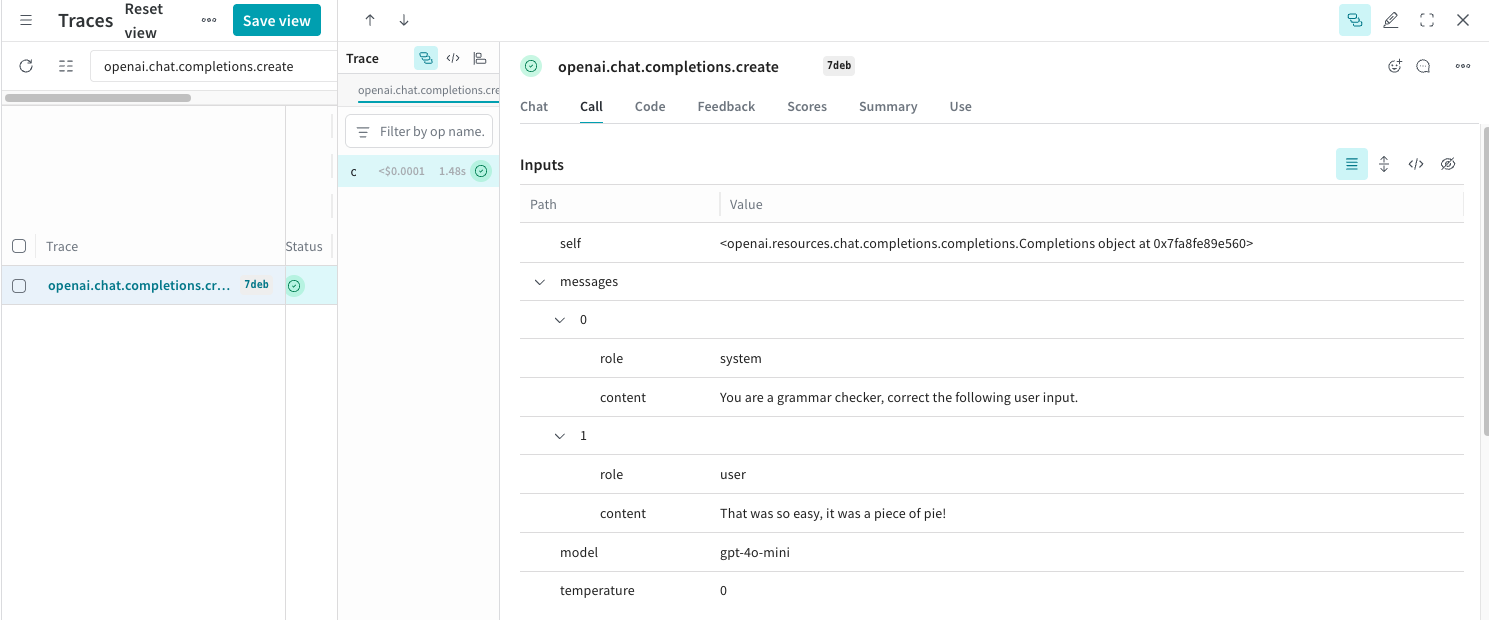

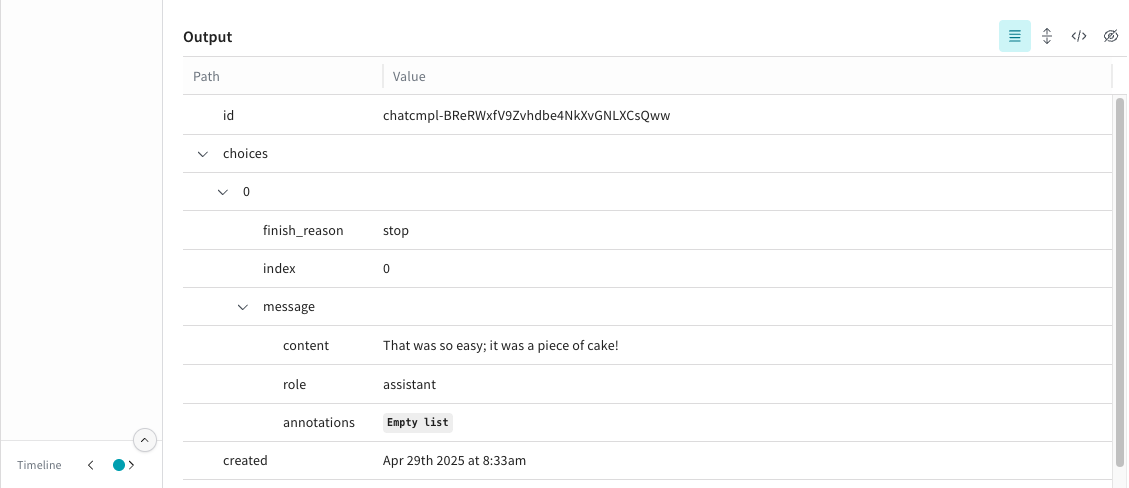

#### But can be integrated with various LLMs

In [8]:
@weave.op()
def strip_user_input(user_input):
    return user_input.strip()

result = strip_user_input("    hello    ")
print(result)

hello
🍩 https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/r/call/01968198-c410-7413-83fb-0be9000d0dc0
🍩 https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/r/call/0196819f-dd56-7a50-9ff4-706e3f4f988d
🍩 https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/r/call/019681be-fe9c-7721-82ce-b63512ba2479


#### Tracing with user defined function

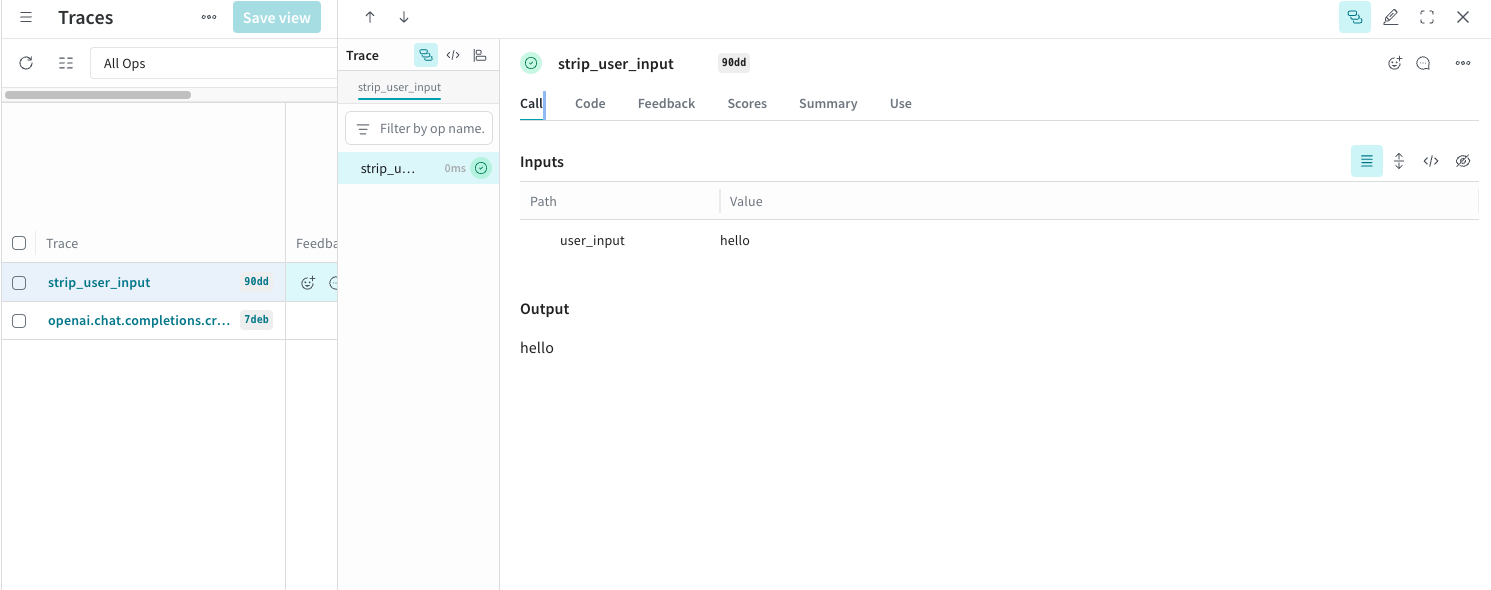

In [9]:
@weave.op()
def strip_user_input(user_input):
    return user_input.strip()


@weave.op()
def correct_grammar(user_input):
    client = OpenAI()

    stripped = strip_user_input(user_input)
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are a grammar checker, correct the following user input.",
            },
            {"role": "user", "content": stripped},
        ],
        temperature=0,
    )
    return response.choices[0].message.content


result = correct_grammar("   That was so easy, it was a piece of pie!    ")
print(result)

That was so easy; it was a piece of cake!


### Track Errors

In [10]:
@weave.op()
def strip_user_input(user_input):
    return user_input.strip()


@weave.op()
def correct_grammar(user_input):
    client = OpenAI()

    stripped = strip_user_input(user_input)
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are a grammar checker, correct the following user input.",
            },
            {"role": "user", "content": stripped},
        ],
        temperature=0,
        response_format={"type": "json_object"},
    )
    return json.loads(response.choices[0].message.content)


result = correct_grammar("   That was so easy, it was a piece of pie!    ")
print(result)

BadRequestError: Error code: 400 - {'error': {'message': "'messages' must contain the word 'json' in some form, to use 'response_format' of type 'json_object'.", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

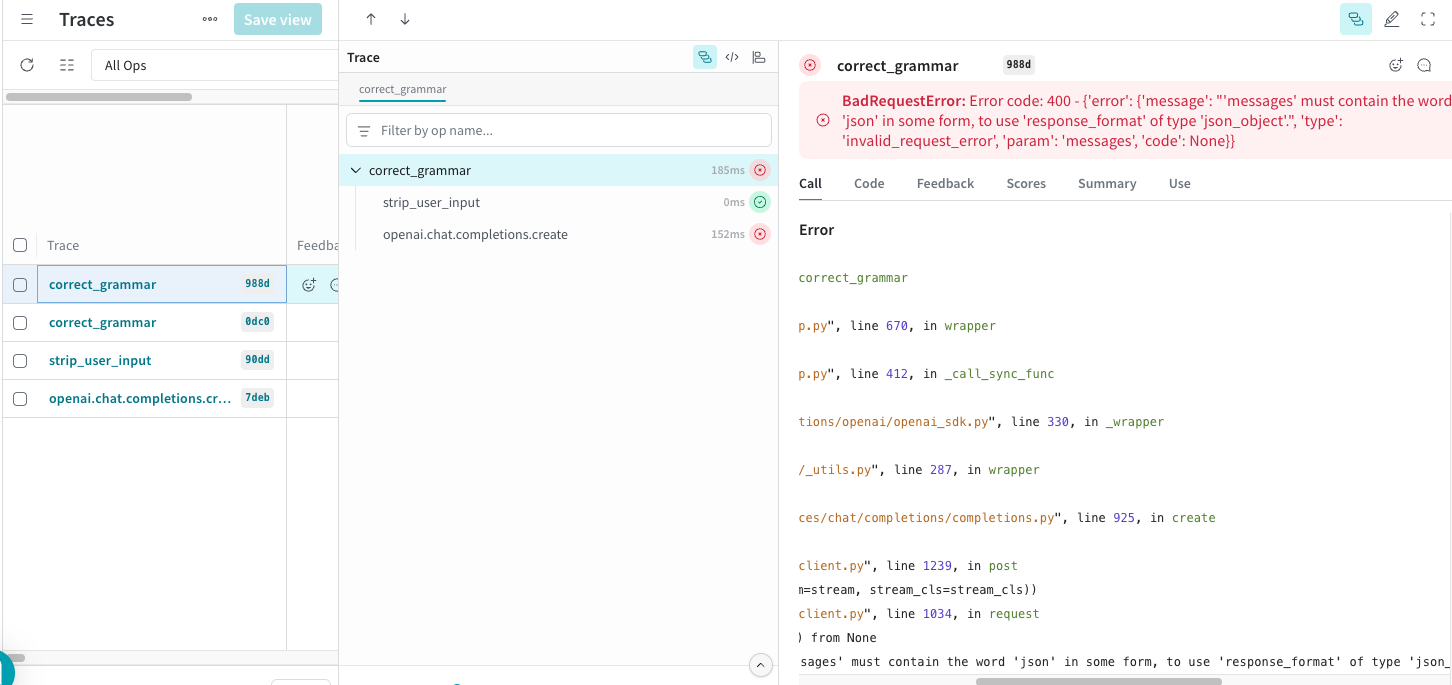

### General Object Tracking

In [11]:
class SystemPrompt(weave.Object):
    prompt: str

system_prompt = SystemPrompt(
    prompt = "You are a grammar checker, correct the following user input."
)
weave.publish(system_prompt)

📦 Published to https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/weave/objects/SystemPrompt/versions/HkHZ1fgB6eUGtxHCLvr91YvPLSpxDTCNx6xRIXibr2Y


ObjectRef(entity='paul-mriganka-personal', project='weave-intro-notebook', name='SystemPrompt', _digest='HkHZ1fgB6eUGtxHCLvr91YvPLSpxDTCNx6xRIXibr2Y', _extra=())

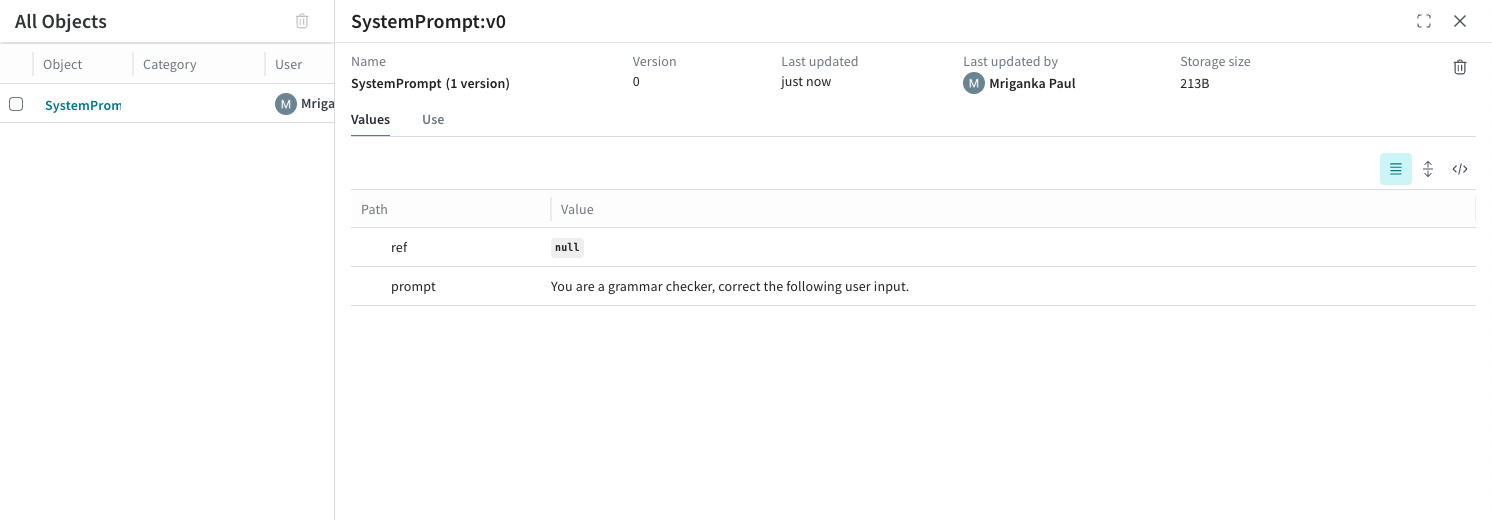

### Model Tracking

In [13]:
class OpenAIGrammarCorrector(weave.Model):
    # Properties are entirely user-defined
    openai_model_name: str
    system_message: str

    @weave.op()
    def predict(self, user_input):
        client = OpenAI()
        response = client.chat.completions.create(
            model=self.openai_model_name,
            messages=[
                {"role": "system", "content": self.system_message},
                {"role": "user", "content": user_input},
            ],
            temperature=0,
        )
        return response.choices[0].message.content

In [14]:
corrector = OpenAIGrammarCorrector(
    openai_model_name="gpt-4o-mini",
    system_message="You are a grammar checker, correct the following user input.",
)

result = corrector.predict("     That was so easy, it was a piece of pie!       ")
print(result)

That was so easy; it was a piece of cake!


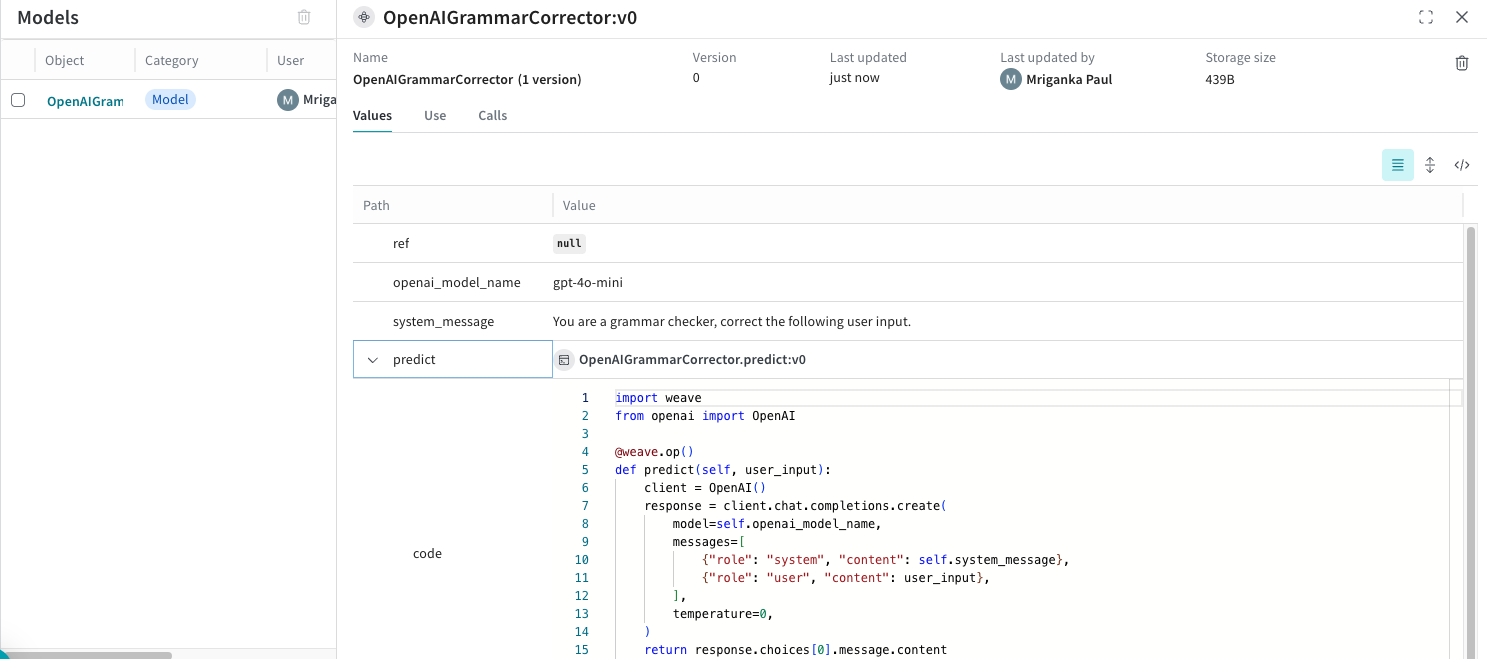

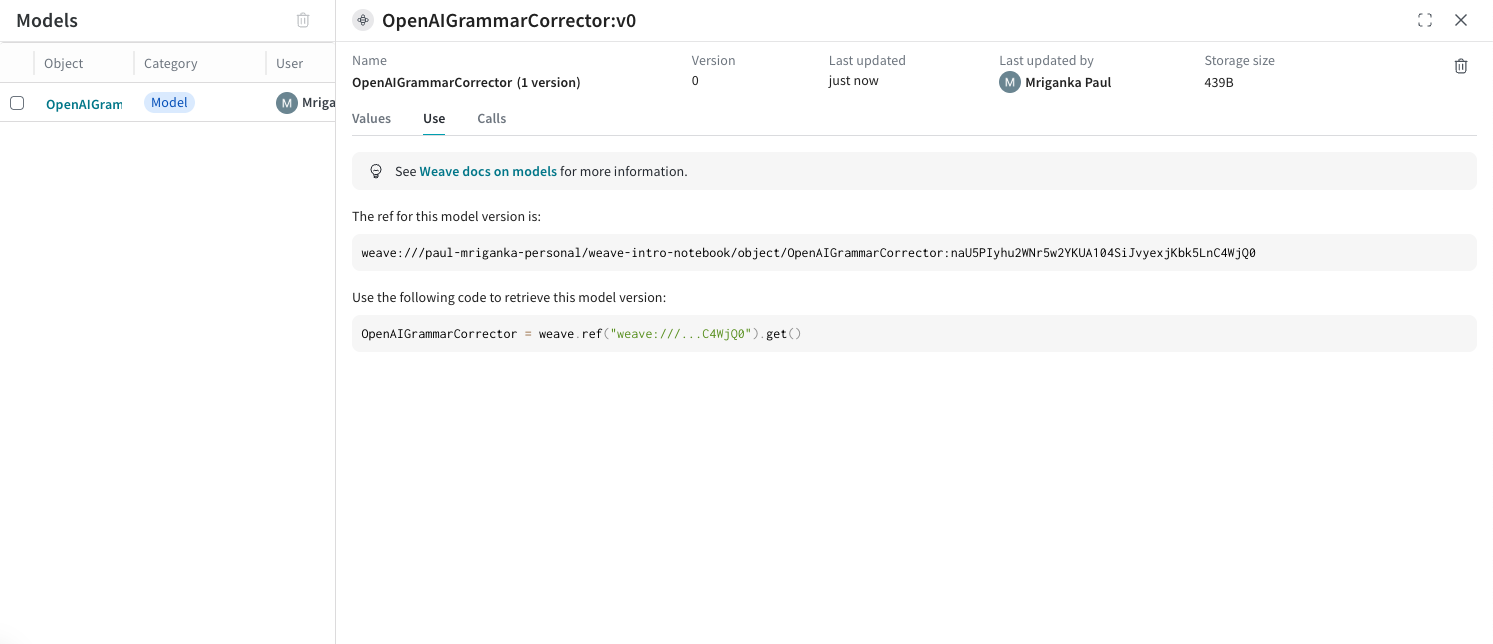

### Dataset Tracking

In [15]:
dataset = weave.Dataset(
    name="grammar-correction",
    rows=[
        {
            "user_input": "   That was so easy, it was a piece of pie!   ",
            "expected": "That was so easy, it was a piece of cake!",
        },
        {"user_input": "  I write good   ", "expected": "I write well"},
        {
            "user_input": "  GPT-4 is smartest AI model.   ",
            "expected": "GPT-4 is the smartest AI model.",
        },
    ],
)

weave.publish(dataset)

📦 Published to https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/weave/objects/grammar-correction/versions/clKX6SizZc5ms3ZYoc4Y5m7e9qolIzBXK01KZjmHNQ4


ObjectRef(entity='paul-mriganka-personal', project='weave-intro-notebook', name='grammar-correction', _digest='clKX6SizZc5ms3ZYoc4Y5m7e9qolIzBXK01KZjmHNQ4', _extra=())

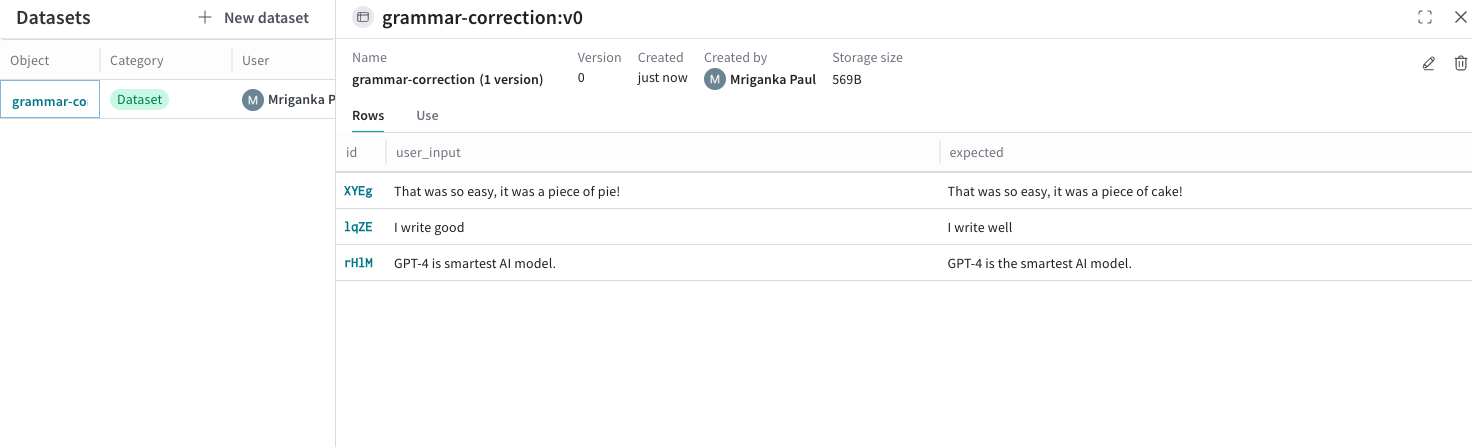

### Retrieve Published object and ops

In [16]:
corrector = OpenAIGrammarCorrector(
    openai_model_name="gpt-4o-mini",
    system_message="You are a grammar checker, correct the following user input.",
)

ref = weave.publish(corrector)
print(ref.uri())

📦 Published to https://wandb.ai/paul-mriganka-personal/weave-intro-notebook/weave/objects/OpenAIGrammarCorrector/versions/naU5PIyhu2WNr5w2YKUA104SiJvyexjKbk5LnC4WjQ0
weave:///paul-mriganka-personal/weave-intro-notebook/object/OpenAIGrammarCorrector:naU5PIyhu2WNr5w2YKUA104SiJvyexjKbk5LnC4WjQ0


In [17]:
ref_url = f"weave:///{ref.entity}/{PROJECT}/object/{ref.name}:{ref.digest}"
ref_url

'weave:///paul-mriganka-personal/weave-intro-notebook/object/OpenAIGrammarCorrector:naU5PIyhu2WNr5w2YKUA104SiJvyexjKbk5LnC4WjQ0'

In [18]:
fetched_collector = weave.ref(ref_url).get()
result = fetched_collector.predict("That was so easy, it was a piece of pie!")
print(result)

That was so easy; it was a piece of cake!


### Evaluation basic

In [20]:
from weave import Evaluation

In [21]:
# Define any custom scoring function
@weave.op()
def exact_match(expected: str, output: dict) -> dict:
    # Here is where you'd define the logic to score the model output
    return {"match": expected == output}


In [22]:
# Score your examples using scoring functions
evaluation = Evaluation(
    dataset=dataset,  # can be a list of dictionaries or a weave.Dataset object
    scorers=[exact_match],  # can be a list of scoring functions
)

In [23]:
summary = await evaluation.evaluate(corrector)  # can be a model or simple function

Error getting code deps for <function Evaluation.summarize at 0x7fa906b0bbe0>: invalid syntax (<unknown>, line 109)


Evaluated 1 of 3 examples

Evaluated 2 of 3 examples

Evaluated 3 of 3 examples

Evaluation summary
{
    'exact_match': {'match': {'true_count': 1, 'true_fraction': 0.3333333333333333}},
    'model_latency': {'mean': 0.45904334386189777}
}